In [76]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [240]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supproting int or float powers"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        
        return out


    def __rmul__(self, other): # other * self
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * other ** -1


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backword():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backword
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [161]:
a = Value(1.0, label='a')
b = Value(2.0, label='b')
a /b 

Value(data=0.5)

In [38]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label= 'd' 
f = Value(-2.0, label='f')
L = d *f; L.label="L"
L

Value(data=-8.0)

In [140]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, creat a rectangular ('node') for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label= n._op )
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


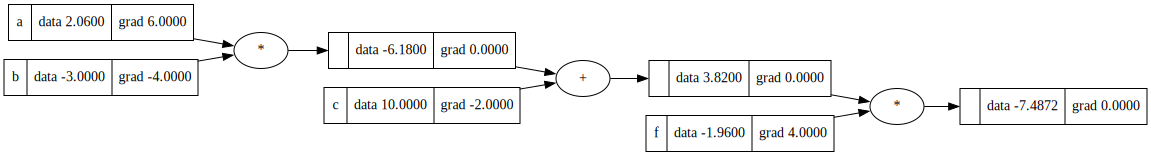

In [86]:
draw_dot(L)

In [70]:
a.data += 0.01 * a.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d *f
L

Value(data=-7.4872000000000005)

In [47]:
L.grad = 1.0

In [71]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label= 'd' 
    f = Value(-2.0, label='f')
    L = d *f; L.label="L"
    L1 = L.data

    a = Value(2.0+ h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c ; d.label= 'd'
    f = Value(-2.0, label='f')
    L = d *f; L.label="L"
    L2 = L.data

    print((L2-L1)/h)

lol()

6.000000000021544


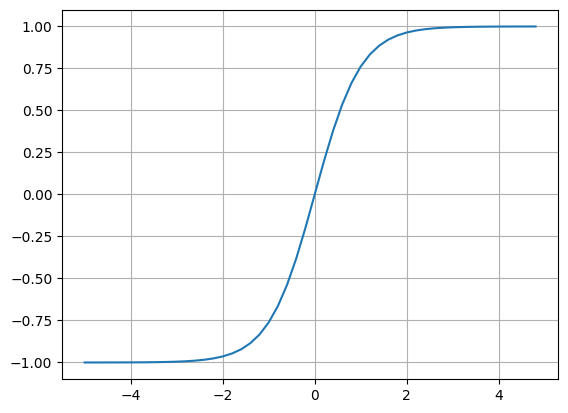

In [78]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [141]:
# input x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.881, label="b")

# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"


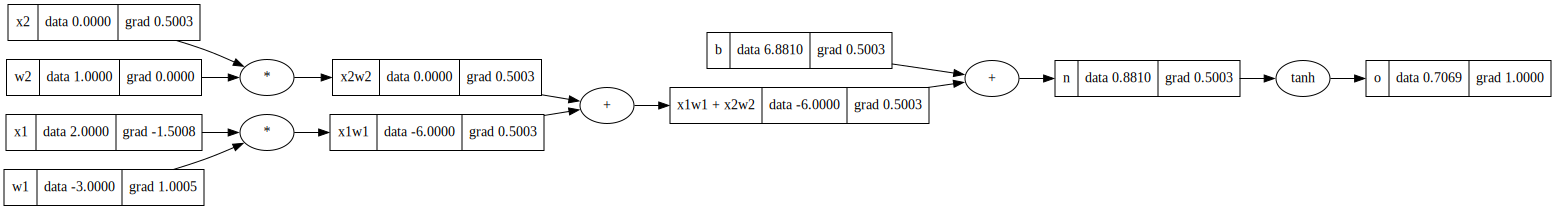

In [144]:
draw_dot(o)

In [143]:
o.backward()

In [137]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


In [128]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

In [165]:
# input x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.881, label="b")

# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"

n = x1w1x2w2 + b; n.label="n"
# ------

e = (2 * n).exp()
o = (e-1)/(e+1)
o.label="o"
# ------

o.backward()

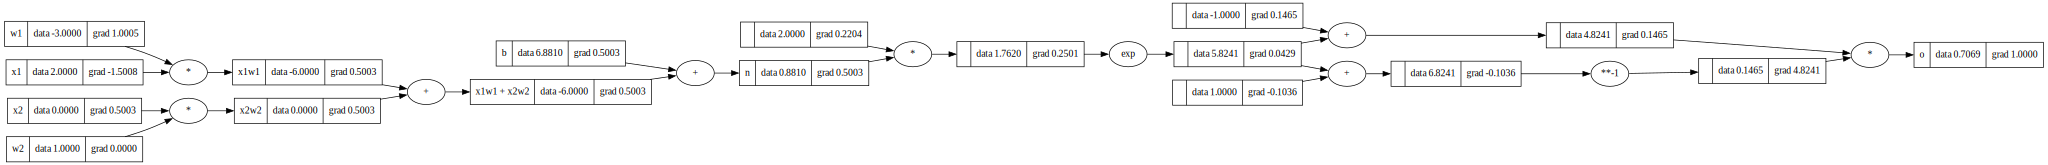

In [166]:
draw_dot(o)

In [184]:
import torch
import random

In [227]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.881]).double() ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-----")
print("x2", x2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())


0.7069199593198744
-----
x2 0.5002641711151872
x1 -1.5007925133455615
w1 1.0005283422303743
w2 0.0


In [251]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)) , self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
        def __init__(self, nin, nout):
            self.neurons = [Neuron(nin) for _ in range(nout)]
    
        def __call__(self, x):
            outs = [n(x) for n in self.neurons]
            return outs[0] if len(outs) == 1 else outs

        def parameters(self):
            return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
        
        def __init__(self, nin, nouts):
            sz = [nin] + nouts
            self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
        def __call__(self, x):
            for layer in self.layers:
                x = layer(x)
            return x

        def parameters(self):
            return [p for layer in self.layers for p in layer.parameters()]


In [254]:
n.parameters()

[Value(data=0.2256477689121017),
 Value(data=0.9503669154089953),
 Value(data=0.3397160660947498),
 Value(data=0.18408178725644064),
 Value(data=-0.47178275800486325),
 Value(data=-0.31588355810860214),
 Value(data=0.8228966401645317),
 Value(data=-0.6850778141679164),
 Value(data=-0.15376172372435692),
 Value(data=-0.9835102741569746),
 Value(data=-0.10080000692612767),
 Value(data=0.12821160852765678),
 Value(data=0.706839522221506),
 Value(data=-0.45995453931950414),
 Value(data=-0.2860709369079617),
 Value(data=0.10710454185069662),
 Value(data=0.8801184352856863),
 Value(data=0.7716310480655808),
 Value(data=-0.3643514617333492),
 Value(data=-0.016166832136906395),
 Value(data=-0.48010872736056087),
 Value(data=-0.8734642221749529),
 Value(data=-0.2619726296285776),
 Value(data=-0.9873768046523186),
 Value(data=-0.7936492803746871),
 Value(data=0.5768187560240863),
 Value(data=-0.659074524476895),
 Value(data=-0.349828753233679),
 Value(data=0.7729636479768607),
 Value(data=0.2772

In [253]:
x = [2.0, 3.0, -1.0]
n = MLP(2,[4, 4, 1])
n(x)

Value(data=-0.6631115399742232)

In [255]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, 2.0, 3.0],
    [0.0, 1.0, 2.0],
    [-1.0, 0.0, 1.0],
]
ys = [1.0, 1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6631115399742232),
 Value(data=-0.6383441599954822),
 Value(data=-0.4773766610045435),
 Value(data=-0.08472626237921356)]

In [259]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [250]:
loss.backword()

AttributeError: 'float' object has no attribute 'backword'